Topic : Fake News Detection

Link Dataset 1: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

Link Dataset 2:
https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification/data

# Import Library and load dataset

In [ ]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import transformers
import torch
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from transformers import AutoModel, BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments


from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
gpu_device_name = tf.test.gpu_device_name()
if gpu_device_name:
    print("GPU device name:", gpu_device_name)
else:
    print("No GPU found.")

TensorFlow version: 2.18.0
GPU device name: /device:GPU:0


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

# welfake_df = pd.read_csv('/content/drive/MyDrive/NLP_Project/WELFake_Dataset.csv')
true_df = pd.read_csv('/content/drive/MyDrive/NLP_Project/True.csv')
fake_df = pd.read_csv('/content/drive/MyDrive/NLP_Project/Fake.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory Data Analysis

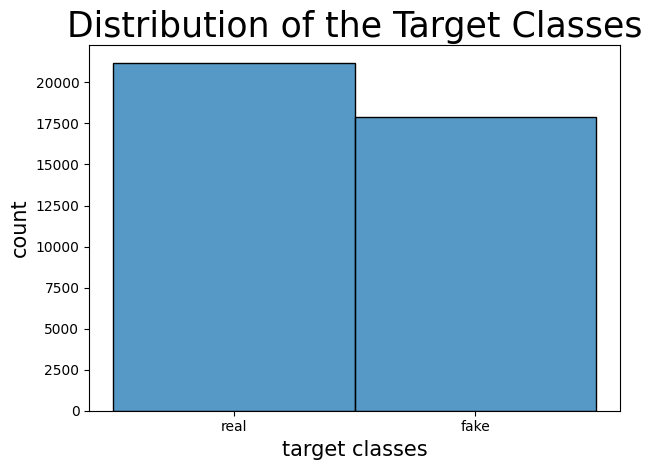

In [ ]:
news_map = {1:'real',0:'fake'}
fake_true['label_names'] = fake_true['label'].map(news_map)

sns.histplot(data=fake_true.label_names)
plt.title('Distribution of the Target Classes',fontsize=25)
plt.xlabel('target classes',fontsize=15)
plt.ylabel('count',fontsize=15)
plt.tight_layout()

# Preprocessing

In [ ]:
true_df

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [ ]:
fake_df

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [ ]:
true_df.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [ ]:
fake_df.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [ ]:
true_df.isnull().sum()

,0
title,0
text,0
subject,0
date,0


In [ ]:
fake_df.isnull().sum()

,0
title,0
text,0
subject,0
date,0


In [ ]:
true_df['label'] = 1
fake_df['label'] = 0

In [ ]:
fake_true = pd.concat([true_df,fake_df])
fake_true

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [ ]:
fake_true.columns

Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')

In [ ]:
fake_true.drop(['subject'], axis=1, inplace=True)
fake_true.drop(['date'], axis=1, inplace=True)
fake_true

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1
...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,0


In [ ]:
print(fake_true.duplicated().sum())

5793


In [ ]:
fake_true.drop_duplicates(inplace=True)

In [ ]:
fake_true.shape

(39105, 3)

In [ ]:
fake_true.isnull().sum()

,0
title,0
text,0
label,0


In [ ]:
# Load data (ganti dengan path file kamu)
df = fake_true  # Jika file csv, atau sesuaikan jika dari sumber lain

# Gabungkan title dan text jika perlu:
# df['text_full'] = df['title'].fillna('') + ' ' + df['text'].fillna('')

In [ ]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [ ]:
def clean(text):
    # Lowercase
    text = text.lower()
    # Hapus non-alphabet & tanda baca
    text = re.sub(r"<.*?>", "", text)  # remove html
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # remove non-alphabetic
    text = re.sub(r"\s+", " ", text).strip()  # remove extra whitespace
    text = re.sub(r"http\S+|www.\S+", "", text)     # Hapus URL

    return text

In [ ]:
# --- PREPROCESSING: STEM + LEMMA ---
def preprocess(text):
    text = clean(text)
    words = text.split()
    processed_words = [
        stemmer.stem(lemmatizer.lemmatize(word))
        for word in words if word not in stop_words
    ]
    return " ".join(processed_words)

In [ ]:
# Terapkan ke data
# df['clean_text'] = df['text_full'].apply(preprocess)
df["clean_text"] = df["text"].apply(preprocess)

In [ ]:
# Vectorization (TF-IDF)
# Instead of simple Bag-of-Words (BoW), we use TF-IDF (Term Frequency-Inverse Document Frequency),
# which gives weightage to important words.


tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
#Use unigrams and bigrams
X = tfidf_vectorizer.fit_transform(df["clean_text"])
y = df["label"]

#Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# Model Training with XGBoost

xgb = XGBClassifier(
    n_estimators=100,         # jumlah pohon
    max_depth=5,              # kedalaman maksimum tiap pohon
    learning_rate=0.1,        # step size shrinkage
    subsample=0.8,            # sampling data (untuk mencegah overfitting)
    colsample_bytree=0.8,     # sampling fitur per pohon
    gamma=1,                  # minimum loss reduction untuk split
    reg_alpha=0.5,            # L1 regularization
    reg_lambda=1,             # L2 regularization
    random_state=42,
    eval_metric='logloss'     # penting untuk classification
)

xgb.fit(X_train, y_train)


# Predict and Evaluate
y_pred_xgb = xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))


Accuracy: 0.9959084516046541
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      3564
           1       0.99      1.00      1.00      4257

    accuracy                           1.00      7821
   macro avg       1.00      1.00      1.00      7821
weighted avg       1.00      1.00      1.00      7821



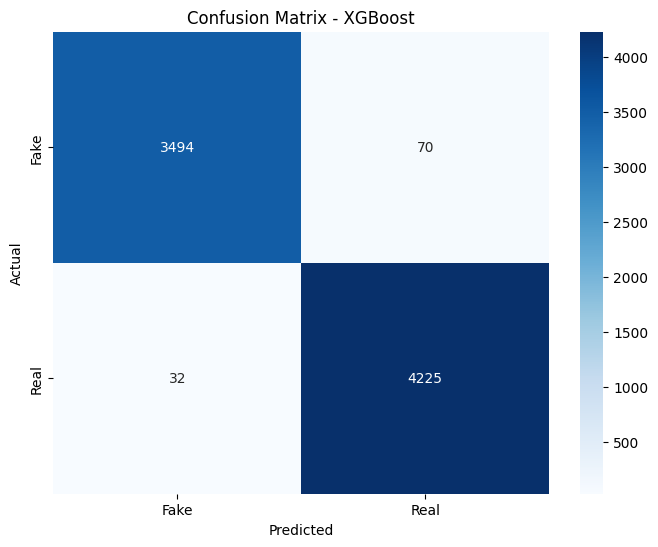

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# Naive Bayes


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Model Training with Naive Bayes
# Train Multinomial Naive Bayes Model
# alpha=0.1, 0.5]

nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train, y_train)


# Predict and Evaluate

y_pred = nb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9324894514767933
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92      3564
           1       0.93      0.95      0.94      4257

    accuracy                           0.93      7821
   macro avg       0.93      0.93      0.93      7821
weighted avg       0.93      0.93      0.93      7821



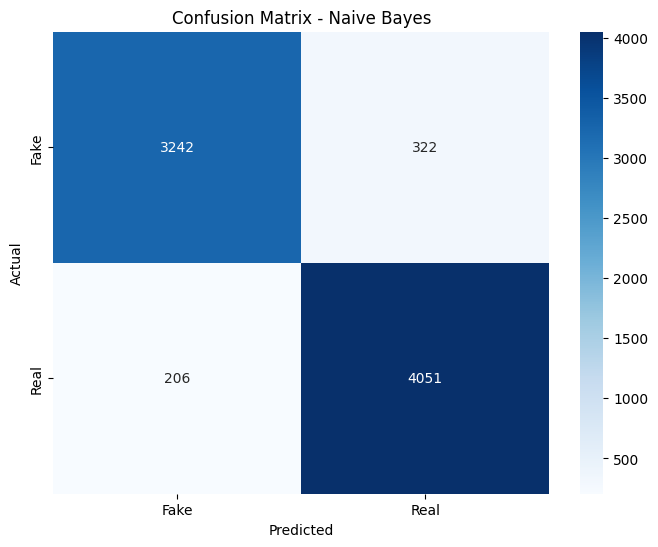

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()


# Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Model Training with Logistic Regression

lr = LogisticRegression()
lr.fit(X_train,y_train)


# Predict and Evaluate
y_pred=lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.986958189489835
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      3564
           1       0.98      0.99      0.99      4257

    accuracy                           0.99      7821
   macro avg       0.99      0.99      0.99      7821
weighted avg       0.99      0.99      0.99      7821



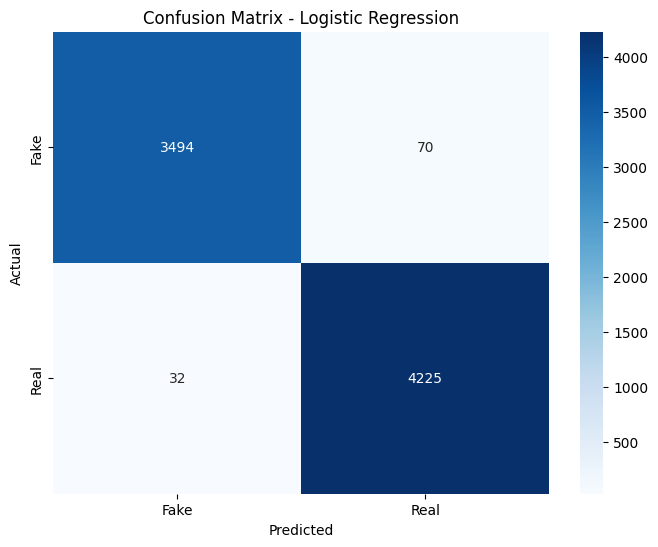

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# Model Training with Random Forest

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


# Predict and Evaluate
y_pred_rf = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Accuracy: 0.995652729829945
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      3564
           1       0.99      1.00      1.00      4257

    accuracy                           1.00      7821
   macro avg       1.00      1.00      1.00      7821
weighted avg       1.00      1.00      1.00      7821



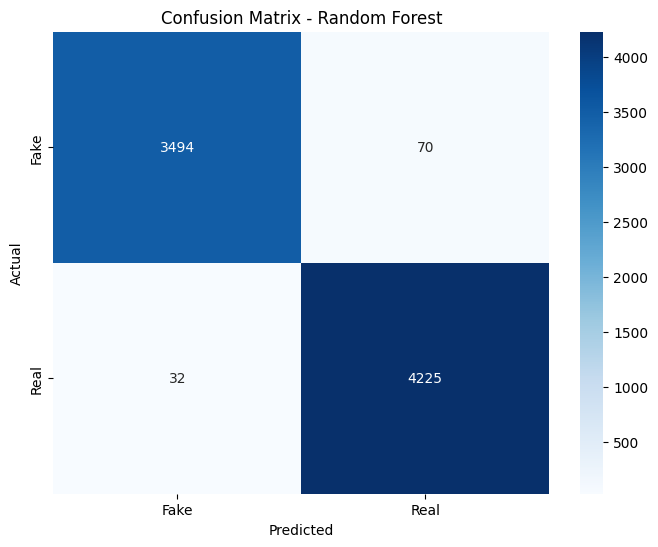

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# SVM

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# Model Training with SVM

svm = LinearSVC(random_state=42)
svm.fit(X_train, y_train)


# Predict and Evaluate
y_pred_svm = svm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))


Accuracy: 0.9925840685334356
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3564
           1       0.99      1.00      0.99      4257

    accuracy                           0.99      7821
   macro avg       0.99      0.99      0.99      7821
weighted avg       0.99      0.99      0.99      7821



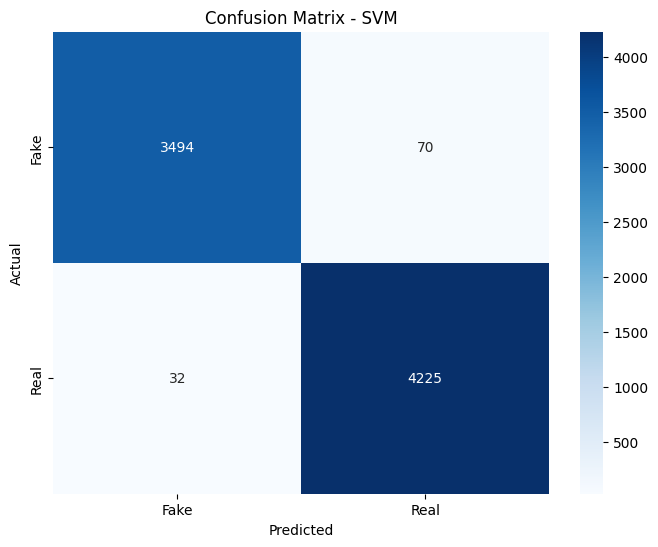

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()